In [9]:
import argparse
import os
import copy

import numpy as np
import json
import torch
from PIL import Image, ImageDraw, ImageFont

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap, get_phrases_from_posmap_2

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image

In [1]:
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128, 128, 128, 128,
           64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128, 64, 128, 128, 192, 128, 128,
           0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128, 128, 64, 128, 0, 192, 128, 128, 192, 128,
           64, 64, 0, 192, 64, 0, 64, 192, 0, 192, 192, 0]

classes = ['aeroplane','bicycle','bird', 'boat','bottle','bus','car','cat','chair',
           'cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep',
           'sofa','train','tvmonitor']

class_dict = dict(zip(classes, list(range(1, 21))))


# print(class_dict)

class_tree = {}
# add some propmt here:
# class_tree['person'] = ['']
class_tree['horse'] = ['halter', 'saddle']
class_tree['diningtable'] = ['bowl','plate','food','fruit','glass', 'dishes']
class_tree['tvmonitor'] = ['tv', 'monitor']
# class_tree['sofa'] = ['couch']
# class_tree['bottle'] = ['wine bottle', 'water bottle', 'canister']
# class_tree['pottedplant'] = ['couch']


for class_name, class_idx in list(class_dict.items()):
    if class_name in class_tree:
        sub_class_list = class_tree[class_name]
        for sub_class in sub_class_list:
            class_dict[sub_class] = class_idx

print(class_dict)
print(class_tree)


def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    # print(load_res)
    _ = model.eval()
    return model

def get_grounding_output(model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]
    print('* filt mask: *', filt_mask.shape, filt_mask.nonzero().shape)
    print('* Boxes filt: *', boxes_filt)
    
    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    
    # breakpoint()
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):

        pred_phrase = get_phrases_from_posmap_2(logit > text_threshold, logit, tokenized, tokenlizer)

        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 
    ax.text(x0, y0, label)

{'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20, 'bowl': 11, 'plate': 11, 'food': 11, 'fruit': 11, 'glass': 11, 'dishes': 11, 'halter': 13, 'saddle': 13, 'tv': 20, 'monitor': 20}
{'horse': ['halter', 'saddle'], 'diningtable': ['bowl', 'plate', 'food', 'fruit', 'glass', 'dishes'], 'tvmonitor': ['tv', 'monitor']}


In [31]:
cls_labels_dict = np.load('metadata/cls_labels.npy',allow_pickle=True).item()

class_label = cls_labels_dict[name]

text_prompt_list = []
for i in range(20):
    if class_label[i] > 1e-5:
        text_prompt_list.append(classes[i])
        if classes[i] in list(class_tree.keys()):
            sub_class_list = class_tree[classes[i]]
            for sub_class in sub_class_list: 
                text_prompt_list.append(sub_class)
        
        # breakpoint()

# if 'pottedplant' not in text_prompt_list:
#     continue

print(text_prompt_list)

if len(text_prompt_list) == 1:
    text_prompt = text_prompt_list[0]
else:
    text_prompt = '.'.join(text_prompt_list)

In [10]:
config_file = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
grounded_checkpoint = "../wsss_sam/groundingdino_swint_ogc.pth"
device = "cuda:1"
im_path = "/mnt/nas/jiaojiao/data/VOCdevkit/VOC2012/JPEGImages"
name = "2007_001149"
# load model
model = load_model(config_file, grounded_checkpoint, device=device)

# load image
image_path = os.path.join(im_path, '{}.jpg'.format(name))
image_pil, image = load_image(image_path)

text_prompt = 'pottedplant.sofa.tvmonitor.tv.monitor'
box_threshold = 0.04 #0.3
text_threshold = 0.25


# run grounding dino model
boxes_filt, pred_phrases = get_grounding_output(
    model, image, text_prompt, box_threshold, text_threshold, with_logits=True, device=device
    )

# sam_checkpoint = '/mnt/nas/jiaojiao/ckpt/sam/sam_vit_l_0b3195.pth' 
sam_checkpoint =  '/mnt/nas/jiaojiao/ckpt/sam/sam_vit_h_4b8939.pth' 
# initialize SAM
predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

size = image_pil.size
H, W = size[1], size[0]
for i in range(boxes_filt.size(0)):
    boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
    boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
    boxes_filt[i][2:] += boxes_filt[i][:2]

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


* boxes_filt: * tensor([], device='cuda:1', size=(0, 4))


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:26                                                                                   │
│                                                                                                  │
│   23 # sam_checkpoint = '/mnt/nas/jiaojiao/ckpt/sam/sam_vit_l_0b3195.pth'                        │
│   24 sam_checkpoint =  '/mnt/nas/jiaojiao/ckpt/sam/sam_vit_h_4b8939.pth'                         │
│   25 # initialize SAM                                                                            │
│ ❱ 26 predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))                   │
│   27 image = cv2.imread(image_path)                                                              │
│   28 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                                              │
│   29 predictor.set_image(image)                                                                  │
│                                                                                                  │
│ /home/jiaojiao/.conda/envs/fusion/lib/python3.7/site-packages/torch/nn/modules/module.py:989 in  │
│ to                                                                                               │
│                                                                                                  │
│    986 │   │   │   │   │   │   │   non_blocking, memory_format=convert_to_format)                │
│    987 │   │   │   return t.to(device, dtype if t.is_floating_point() or t.is_complex() else No  │
│    988 │   │                                                                                     │
│ ❱  989 │   │   return self._apply(convert)                                                       │
│    990 │                                                                                         │
│    991 │   def register_backward_hook(                                                           │
│    992 │   │   self, hook: Callable[['Module', _grad_t, _grad_t], Union[None, Tensor]]           │
│                                                                                                  │
│ /home/jiaojiao/.conda/envs/fusion/lib/python3.7/site-packages/torch/nn/modules/module.py:641 in  │
│ _apply                                                                                           │
│                                                                                                  │
│    638 │                                                                                         │
│    639 │   def _apply(self, fn):                                                                 │
│    640 │   │   for module in self.children():                                                    │
│ ❱  641 │   │   │   module._apply(fn)                                                             │
│    642 │   │                                                                                     │
│    643 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    644 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ /home/jiaojiao/.conda/envs/fusion/lib/python3.7/site-packages/torch/nn/modules/module.py:641 in  │
│ _apply                                                                                           │
│                                                                                                  │
│    638 │                                                                                         │
│    639 │   def _apply(self, fn):                                                                 │
│    640 │   │   for module in self.children():                                                    │
│ ❱  641 │   │   │   module._apply(fn)                       

In [ ]:
boxes_filt = boxes_filt.cpu()
transformed_boxes = predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

try:
    masks, scores, _ = predictor.predict_torch(
        point_coords = None,
        point_labels = None,
        boxes = transformed_boxes.to(device),
        multimask_output = False,
    )
        
except: # in case nothing detected
    masks = []
        

In [ ]:
mask[0].nonzero()

In [43]:
masks

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

for i, (mask,score) in enumerate(zip(masks, scores)):
    show_mask(mask.cpu().numpy()[0,::], plt.gca(), random_color=True)
for box, label in zip(boxes_filt, pred_phrases):
    show_box(box.numpy(), plt.gca(), label)

# plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
plt.axis('off')

In [48]:
boxes_filt

In [6]:
import argparse
import os
import copy

import numpy as np
import json
import torch
from PIL import Image, ImageDraw, ImageFont

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap, get_phrases_from_posmap_2

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from tqdm import tqdm


palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128, 128, 128, 128,
           64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128, 64, 128, 128, 192, 128, 128,
           0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128, 128, 64, 128, 0, 192, 128, 128, 192, 128,
           64, 64, 0, 192, 64, 0, 64, 192, 0, 192, 192, 0]

classes = ['aeroplane','bicycle','bird', 'boat','bottle','bus','car','cat','chair',
           'cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep',
           'sofa','train','tvmonitor']

class_dict = dict(zip(classes, list(range(1, 21))))

# print(class_dict)

class_tree = {}
# add some propmt here:
# class_tree['person'] = ['']
class_tree['horse'] = ['halter', 'saddle']
class_tree['diningtable'] = ['bowl','plate','food','fruit','glass', 'dishes']
class_tree['tvmonitor'] = ['tv', 'monitor']
class_tree['sofa'] = ['couch']
class_tree['bottle'] = ['wine bottle', 'water bottle', 'canister']
class_tree['pottedplant'] = ['couch']


for class_name, class_idx in list(class_dict.items()):
    if class_name in class_tree:
        sub_class_list = class_tree[class_name]
        for sub_class in sub_class_list:
            class_dict[sub_class] = class_idx

print(class_dict)
print(class_tree)


def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
#     checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    checkpoint = torch.load(model_checkpoint_path, map_location=device) # debug
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    # print(load_res)
    _ = model.eval()
    return model

def get_grounding_output(model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    # todo: debug
#     if device == "cpu":
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
#     else:
#         logits = outputs["pred_logits"].sigmoid()[0]  # (nq, 256)
#         boxes = outputs["pred_boxes"][0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    
    # breakpoint()
    # build pred
    pred_phrases = []
#     boxes_filt = torch.tensor()
#     logits_filt = 
#     print('* boxes_filt: *, there is bug !!! ', boxes_filt,logits_filt, caption ) #todo: debug, pred_phrase 
    for logit, box in zip(logits_filt, boxes_filt):

        pred_phrase = get_phrases_from_posmap_2(logit > text_threshold, logit, tokenized, tokenlizer)
#         print('* pred_phrase: *', pred_phrase) #todo: debug, pred_phrase 

        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 
    ax.text(x0, y0, label)


def save_mask_data(output_dir, mask_list, box_list, label_list, name, H, W):
    value = 0  # 0 for background

    mask_img = torch.zeros(H, W)
    for idx, mask in enumerate(mask_list):
        class_name, logit = label_list[idx].split('(')
        if class_name in class_dict:
            class_idx = class_dict[class_name]
            mask_img[mask.cpu().numpy()[0] == True] = class_idx 
    

    out = mask_img.numpy().astype(np.uint8)
    out = Image.fromarray(out, mode='P')
    out.putpalette(palette)
    out_name = os.path.join(output_dir, '{}.png'.format(name))
    out.save(out_name)


    json_data = [{
        'value': value,
        'label': 'background'
    }]

    for label, box in zip(label_list, box_list):
        value += 1
        name, logit = label.split('(')
        logit = logit[:-1] # the last is ')'
        json_data.append({
            'value': value,
            'label': name,
            'logit': float(logit),
            'box': box.numpy().tolist(),
        })
    with open(os.path.join(output_dir, 'mask.json'), 'w') as f:
        json.dump(json_data, f)
    

# if __name__ == "__main__":
def main(num):

#     parser = argparse.ArgumentParser("Grounded-Segment-Anything Demo", add_help=True)
#     parser.add_argument("--config", type=str, required=True, help="path to config file")
#     parser.add_argument(
#         "--grounded_checkpoint", type=str, required=True, help="path to checkpoint file"
#     )
#     parser.add_argument(
#         "--sam_checkpoint", type=str, required=True, help="path to checkpoint file"
#     )
#     parser.add_argument("--input_image", type=str, required=True, help="path to image file")
#     parser.add_argument("--img_list", type=str, required=True, default='metadata/pascal/train_aug(id).txt')
#     parser.add_argument("--im_path", default="/home/notebook/data/personal/S9050086/VOCdevkit/VOC2012/JPEGImages", type=str)


#     parser.add_argument(
#         "--output_dir", "-o", type=str, default="outputs", required=True, help="output directory"
#     )   

#     parser.add_argument("--box_threshold", type=float, default=0.3, help="box threshold")
#     parser.add_argument("--text_threshold", type=float, default=0.25, help="text threshold")

#     parser.add_argument("--device", type=str, default="cpu", help="running on cpu only!, default=False")
#     args = parser.parse_args()
    
    config = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
    grounded_checkpoint = "../wsss_sam/groundingdino_swint_ogc.pth" 
    sam_checkpoint = "/mnt/nas/jiaojiao/ckpt/sam/sam_vit_h_4b8939.pth" 
    box_threshold = 0.3 
    text_threshold = 0.25 
    device = "cuda" 
    im_path = "/mnt/nas/kaichen/cityscape/leftImg8bit/train/stuttgart/"
    output_dir = "cityscapes_train_stuttgart" 
#     input_image = "/mnt/nas/jiaojiao/data/VOCdevkit/VOC2012/JPEGImages/2012_004331.jpg"
    img_list = os.listdir(im_path)
    datatype = "cityscapes" #["voc", "cityscapes"]

    if datatype == "voc":
        img_list = "/mnt/nas/jiaojiao/2024/wsss_sam/metadata/pascal/train_aug(id).txt"
        im_path = "/mnt/nas/jiaojiao/data/VOCdevkit/VOC2012/JPEGImages"
        output_dir = "pascal_train" 
        with open(img_list) as f:
            img_list = []
            for line in f:
                img_list.append(line[:-1])
    
    cls_labels_dict = np.load('metadata/cls_labels.npy',allow_pickle=True).item()
    
    # cfg
    config_file = config  # change the path of the model config file
    grounded_checkpoint = grounded_checkpoint  # change the path of the model
    sam_checkpoint = sam_checkpoint
    output_dir = output_dir
    box_threshold = box_threshold
    text_threshold = text_threshold
    device = device

    print("** Load Model **")
    # load model
    model = load_model(config_file, grounded_checkpoint, device=device)

    # make dir
    os.makedirs(output_dir, exist_ok=True)

    # initialize SAM
    predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

    print("** Load image **")
    j=0
    for index, name in tqdm(enumerate(img_list[:num])):

        if name+".png" in os.listdir(output_dir):
            continue
            
        # load image
        if datatype == "voc":
            image_path = os.path.join(im_path, '{}.jpg'.format(name))
        elif datatype == "cityscapes":       
            image_path = os.path.join(im_path, name)
        
        image_pil, image = load_image(image_path)

        # get text prompt
        if datatype == "cityscapes":
#             text_prompt = "car.person.motorcycle" 
            text_prompt = annot_list
            name = name.replace(".png", "")
        elif datatype == "voc":
            class_label = cls_labels_dict[name]
            text_prompt_list = []
            for i in range(20):
                if class_label[i] > 1e-5:
                    text_prompt_list.append(classes[i])
                    if classes[i] in list(class_tree.keys()):
                        sub_class_list = class_tree[classes[i]]
                        for sub_class in sub_class_list: 
                            text_prompt_list.append(sub_class)
        
        # breakpoint()

    #         if 'pottedplant' not in text_prompt_list:
    #             continue

            if len(text_prompt_list) == 1:
                text_prompt = text_prompt_list[0]
            else:
                text_prompt = '.'.join(text_prompt_list)
            
        j+=1
        print(j,index, name,  '--', text_prompt)

        # visualize raw image
        # image_pil.save(os.path.join(output_dir, "{}.jpg".format(name)))
        
        # run grounding dino model
        boxes_filt, pred_phrases = get_grounding_output(
            model, image, text_prompt, box_threshold, text_threshold, with_logits=True, device=device
        )

        print("boxes_filt ", boxes_filt, "pred_phrases ", pred_phrases)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image)

        size = image_pil.size
        H, W = size[1], size[0]
        for i in range(boxes_filt.size(0)):
            boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
            boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
            boxes_filt[i][2:] += boxes_filt[i][:2]

        boxes_filt = boxes_filt.cpu()
        transformed_boxes = predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

        try:
            masks, _, _ = predictor.predict_torch(
                point_coords = None,
                point_labels = None,
                boxes = transformed_boxes.to(device),
                multimask_output = False,
            )
        
        except: # in case nothing detected
            masks = []
        
        # print(pred_phrases)

        # draw output image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
#         plt.show()

        for mask in masks:
            show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
        for box, label in zip(boxes_filt, pred_phrases):
            show_box(box.numpy(), plt.gca(), label)

        plt.axis('off')
        plt.savefig(
            os.path.join(output_dir, "{}_sam.jpg".format(name)), 
            bbox_inches="tight", dpi=300, pad_inches=0.0
        )

        save_mask_data(output_dir, masks, boxes_filt, pred_phrases, name, H, W)
        plt.show()
        plt.close()



{'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20, 'wine bottle': 5, 'water bottle': 5, 'canister': 5, 'bowl': 11, 'plate': 11, 'food': 11, 'fruit': 11, 'glass': 11, 'dishes': 11, 'halter': 13, 'saddle': 13, 'couch': 18, 'tv': 20, 'monitor': 20}
{'horse': ['halter', 'saddle'], 'diningtable': ['bowl', 'plate', 'food', 'fruit', 'glass', 'dishes'], 'tvmonitor': ['tv', 'monitor'], 'sofa': ['couch'], 'bottle': ['wine bottle', 'water bottle', 'canister'], 'pottedplant': ['couch']}


** Load Model **
final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


** Load image **


0it [00:00, ?it/s]

1 0 stuttgart_000110_000019_leftImg8bit -- unlabeled.egovehicle.rectificationborder.outofroi.static.dynamic.ground.road.sidewalk.parking.railtrack.building.wall.fence.guardrail.bridge.tunnel.pole.polegroup.trafficlight.trafficsign.vegetation.terrain.sky.person.rider.car.truck.bus.caravan.trailer.train.motorcycle.bicycle.licenseplate
boxes_filt  tensor([[0.3907, 0.6048, 0.1052, 0.5200],
        [0.7832, 0.5541, 0.0517, 0.2759],
        [0.7986, 0.5349, 0.0376, 0.2708],
        [0.5581, 0.5935, 0.1203, 0.6156],
        [0.3846, 0.3283, 0.0240, 0.0628],
        [0.6701, 0.1787, 0.0483, 0.1210],
        [0.6611, 0.3990, 0.0189, 0.0933],
        [0.5004, 0.8004, 0.9958, 0.3918],
        [0.3870, 0.3608, 0.0413, 0.1306],
        [0.8299, 0.6316, 0.3367, 0.1992],
        [0.3786, 0.3545, 0.0825, 0.2352],
        [0.6324, 0.2073, 0.0323, 0.0704],
        [0.6531, 0.5206, 0.0297, 0.3848],
        [0.5002, 0.8418, 0.9947, 0.3068],
        [0.6549, 0.3933, 0.0329, 0.1253],
        [0.3230, 0.5366

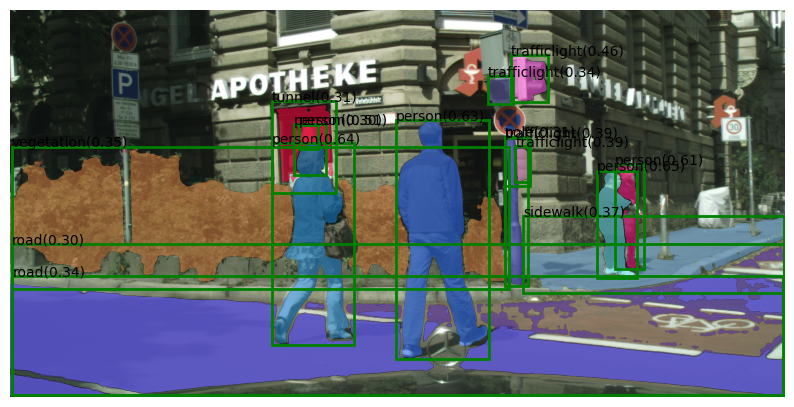

1it [01:10, 70.06s/it]

2 1 stuttgart_000107_000019_leftImg8bit -- unlabeled.egovehicle.rectificationborder.outofroi.static.dynamic.ground.road.sidewalk.parking.railtrack.building.wall.fence.guardrail.bridge.tunnel.pole.polegroup.trafficlight.trafficsign.vegetation.terrain.sky.person.rider.car.truck.bus.caravan.trailer.train.motorcycle.bicycle.licenseplate
boxes_filt  tensor([[0.3479, 0.5222, 0.0432, 0.1518],
        [0.2220, 0.4810, 0.0389, 0.2453],
        [0.3477, 0.4624, 0.0443, 0.1931],
        [0.1347, 0.5477, 0.1873, 0.2559],
        [0.4523, 0.1068, 0.2211, 0.2109],
        [0.2791, 0.4910, 0.0950, 0.1461],
        [0.4759, 0.4271, 0.0297, 0.0405],
        [0.7994, 0.6349, 0.3980, 0.3185],
        [0.0653, 0.5850, 0.1296, 0.3493],
        [0.5656, 0.4514, 0.0830, 0.1330],
        [0.1675, 0.4189, 0.0279, 0.0673],
        [0.4277, 0.4296, 0.0218, 0.0307],
        [0.4999, 0.6728, 0.9948, 0.6448],
        [0.3233, 0.4675, 0.0328, 0.0935],
        [0.5084, 0.4424, 0.0235, 0.0559],
        [0.3928, 0.4455

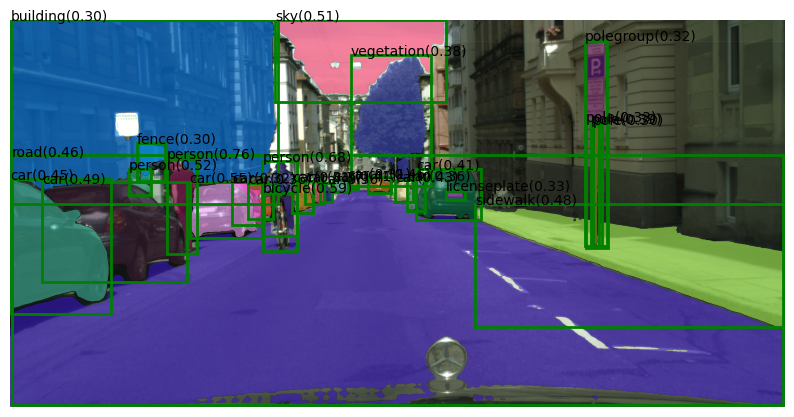

2it [03:42, 118.23s/it]

3 2 stuttgart_000087_000019_leftImg8bit -- unlabeled.egovehicle.rectificationborder.outofroi.static.dynamic.ground.road.sidewalk.parking.railtrack.building.wall.fence.guardrail.bridge.tunnel.pole.polegroup.trafficlight.trafficsign.vegetation.terrain.sky.person.rider.car.truck.bus.caravan.trailer.train.motorcycle.bicycle.licenseplate
boxes_filt  tensor([[0.8326, 0.3924, 0.0508, 0.2749],
        [0.3154, 0.4209, 0.2074, 0.2705],
        [0.6914, 0.1351, 0.0177, 0.0876],
        [0.5482, 0.4049, 0.1893, 0.3281],
        [0.5211, 0.2081, 0.0254, 0.0383],
        [0.3114, 0.2147, 0.0382, 0.0433],
        [0.6035, 0.0305, 0.0106, 0.0394],
        [0.8200, 0.6791, 0.3570, 0.6148],
        [0.0195, 0.2995, 0.0385, 0.1315],
        [0.5434, 0.1998, 0.0253, 0.0437],
        [0.4803, 0.2013, 0.0395, 0.0525],
        [0.4910, 0.2940, 0.0940, 0.1338],
        [0.7132, 0.2061, 0.0312, 0.0488],
        [0.4729, 0.2992, 0.0571, 0.1223],
        [0.4992, 0.6035, 0.9939, 0.7792],
        [0.7894, 0.1411

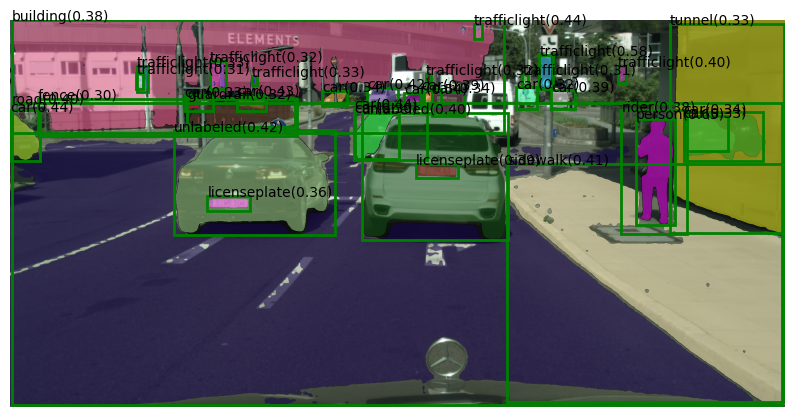

3it [07:00, 154.86s/it]

4 3 stuttgart_000188_000019_leftImg8bit -- unlabeled.egovehicle.rectificationborder.outofroi.static.dynamic.ground.road.sidewalk.parking.railtrack.building.wall.fence.guardrail.bridge.tunnel.pole.polegroup.trafficlight.trafficsign.vegetation.terrain.sky.person.rider.car.truck.bus.caravan.trailer.train.motorcycle.bicycle.licenseplate
boxes_filt  tensor([[0.9394, 0.5770, 0.1185, 0.3473],
        [0.0512, 0.5493, 0.1003, 0.3194],
        [0.5382, 0.4267, 0.0131, 0.0793],
        [0.5509, 0.4238, 0.0146, 0.0803],
        [0.1359, 0.4464, 0.0181, 0.1207],
        [0.7056, 0.4485, 0.0282, 0.1200],
        [0.1104, 0.4489, 0.0173, 0.1181],
        [0.3896, 0.4546, 0.0692, 0.1068],
        [0.2928, 0.4289, 0.0169, 0.0575],
        [0.9573, 0.3843, 0.0230, 0.0959],
        [0.5853, 0.3939, 0.0148, 0.0490],
        [0.5333, 0.1450, 0.1889, 0.2858],
        [0.5861, 0.3958, 0.0430, 0.1296],
        [0.9618, 0.3998, 0.0331, 0.1285],
        [0.1684, 0.2609, 0.3335, 0.5158],
        [0.5281, 0.4236

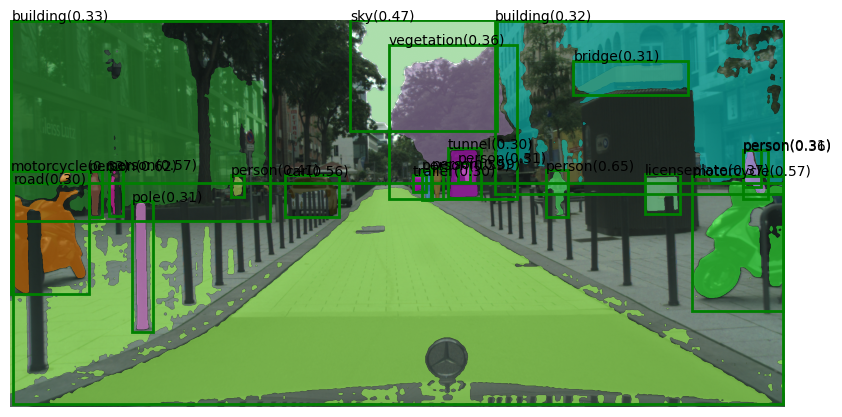

4it [09:13, 146.10s/it]

5 4 stuttgart_000175_000019_leftImg8bit -- unlabeled.egovehicle.rectificationborder.outofroi.static.dynamic.ground.road.sidewalk.parking.railtrack.building.wall.fence.guardrail.bridge.tunnel.pole.polegroup.trafficlight.trafficsign.vegetation.terrain.sky.person.rider.car.truck.bus.caravan.trailer.train.motorcycle.bicycle.licenseplate
boxes_filt  tensor([[0.7925, 0.5265, 0.1231, 0.4531],
        [0.4442, 0.4642, 0.0719, 0.3563],
        [0.4476, 0.5473, 0.1641, 0.2456],
        [0.6419, 0.4311, 0.0320, 0.0789],
        [0.6634, 0.2796, 0.0095, 0.0380],
        [0.6171, 0.4534, 0.0193, 0.0255],
        [0.0647, 0.5454, 0.1273, 0.1403],
        [0.8574, 0.4503, 0.0771, 0.1105],
        [0.7653, 0.4480, 0.0183, 0.0683],
        [0.7141, 0.4528, 0.0199, 0.0343],
        [0.9651, 0.4657, 0.0677, 0.1402],
        [0.5264, 0.3867, 0.0081, 0.0336],
        [0.6172, 0.1678, 0.3924, 0.3309],
        [0.9047, 0.2323, 0.1880, 0.4605],
        [0.1848, 0.8024, 0.3652, 0.3836],
        [0.5392, 0.4422

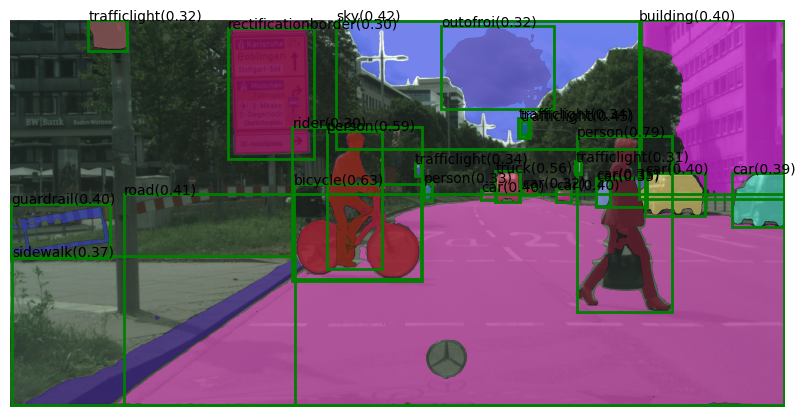

5it [10:56, 130.78s/it]

6 5 stuttgart_000147_000019_leftImg8bit -- unlabeled.egovehicle.rectificationborder.outofroi.static.dynamic.ground.road.sidewalk.parking.railtrack.building.wall.fence.guardrail.bridge.tunnel.pole.polegroup.trafficlight.trafficsign.vegetation.terrain.sky.person.rider.car.truck.bus.caravan.trailer.train.motorcycle.bicycle.licenseplate
boxes_filt  tensor([[0.3002, 0.4674, 0.1481, 0.2057],
        [0.6422, 0.4423, 0.0979, 0.1416],
        [0.5002, 0.6473, 0.9945, 0.6936],
        [0.3929, 0.4395, 0.0707, 0.1191],
        [0.3235, 0.4109, 0.0292, 0.0471],
        [0.4512, 0.3977, 0.0456, 0.0654],
        [0.8623, 0.5292, 0.2721, 0.3844],
        [0.4775, 0.3746, 0.0242, 0.0467],
        [0.2843, 0.4110, 0.0258, 0.0469],
        [0.4105, 0.4285, 0.0360, 0.1036],
        [0.9336, 0.5456, 0.0675, 0.0498],
        [0.1280, 0.5871, 0.2124, 0.2075],
        [0.5871, 0.4025, 0.0409, 0.0654],
        [0.0808, 0.3491, 0.0575, 0.3766],
        [0.4864, 0.3525, 0.0241, 0.0377],
        [0.4123, 0.3359

In [ ]:
main(10)

In [3]:
# cityscape list
text = [
    {"name": "unlabeled", "color": "#000000", "attributes": []},
    {"name": "egovehicle", "color": "#000000", "attributes": []},
    {"name": "rectificationborder", "color": "#000000", "attributes": []},
    {"name": "outofroi", "color": "#000000", "attributes": []},
    {"name": "static", "color": "#000000", "attributes": []},
    {"name": "dynamic", "color": "#6f4a00", "attributes": []},
    {"name": "ground", "color": "#510051", "attributes": []},
    {"name": "road", "color": "#804080", "attributes": []},
    {"name": "sidewalk", "color": "#f423e8", "attributes": []},
    {"name": "parking", "color": "#faaaa0", "attributes": []},
    {"name": "railtrack", "color": "#e6968c", "attributes": []},
    {"name": "building", "color": "#464646", "attributes": []},
    {"name": "wall", "color": "#66669c", "attributes": []},
    {"name": "fence", "color": "#be9999", "attributes": []},
    {"name": "guardrail", "color": "#b4a5b4", "attributes": []},
    {"name": "bridge", "color": "#966464", "attributes": []},
    {"name": "tunnel", "color": "#96785a", "attributes": []},
    {"name": "pole", "color": "#999999", "attributes": []},
    {"name": "polegroup", "color": "#999999", "attributes": []},
    {"name": "trafficlight", "color": "#faaa1e", "attributes": []},
    {"name": "trafficsign", "color": "#dcdc00", "attributes": []},
    {"name": "vegetation", "color": "#6b8e23", "attributes": []},
    {"name": "terrain", "color": "#98fb98", "attributes": []},
    {"name": "sky", "color": "#4682b4", "attributes": []},
    {"name": "person", "color": "#dc143c", "attributes": []},
    {"name": "rider", "color": "#ff0000", "attributes": []},
    {"name": "car", "color": "#00008e", "attributes": []},
    {"name": "truck", "color": "#000046", "attributes": []},
    {"name": "bus", "color": "#003c64", "attributes": []},
    {"name": "caravan", "color": "#00005a", "attributes": []},
    {"name": "trailer", "color": "#00006e", "attributes": []},
    {"name": "train", "color": "#005064", "attributes": []},
    {"name": "motorcycle", "color": "#0000e6", "attributes": []},
    {"name": "bicycle", "color": "#770b20", "attributes": []},
    {"name": "licenseplate", "color": "#00000e", "attributes": []}
]

annot_list = text[0]["name"]
for t in text[1:]:
    annot_list += "."+ t["name"]
annot_list

'unlabeled.egovehicle.rectificationborder.outofroi.static.dynamic.ground.road.sidewalk.parking.railtrack.building.wall.fence.guardrail.bridge.tunnel.pole.polegroup.trafficlight.trafficsign.vegetation.terrain.sky.person.rider.car.truck.bus.caravan.trailer.train.motorcycle.bicycle.licenseplate'